In [1]:
import pandas as pd
import numpy as np
df_original = pd.read_excel('yearly_data.xlsx', header=3)

In [2]:
# Drop columns
df = df_original.drop(df_original.columns[[2,3,6]], axis=1)

# Rename columns
renamed_columns = {
    'FLO start US/Eastern ': 'date_time',
    'Hour Starting': 'hour',
    'Total Delivered Energy Cost ($/MWh)': 'cost_elec',
    'Outside Temp F': 'T_OA',
    'House Power Required AvgKw': 'Q_load'
}
df.rename(columns=renamed_columns, inplace=True)

# Convert outside air temperature from °F to °C
df['T_OA'] = df['T_OA'].apply(lambda x: round(5/9 * (x-32),2))

# Convert Q_load (W) to m_load (kg/s)
cp, Delta_T_load = 4187, 11.111
df['Q_load'] = df['Q_load'].apply(lambda x: round(x*1000/cp/Delta_T_load,3))
df.rename(columns={'Q_load': 'm_load'}, inplace=True)

# Keep only date
df['date_time'] = df['date_time'].dt.date
df.rename(columns={'date_time': 'date'}, inplace=True)

df.head()

,date,hour,cost_elec,T_OA,m_load
0,2022-01-01,00:00,69.39,-3.89,0.127
1,2022-01-01,01:00,64.75,-3.33,0.124
2,2022-01-01,02:00,63.84,-2.78,0.122
3,2022-01-01,03:00,63.31,-3.33,0.124
4,2022-01-01,04:00,63.17,-3.33,0.123


In [3]:
# Check correlation between T_OA and m_load
from scipy import stats
correlation, p_value = stats.spearmanr(df.T_OA, df.m_load)
print(f"Correlation: {round(correlation,2)}, p-value: {p_value}")

# Running the whole code with df['T_OA'] = df['m_load'] pretty much doesn't change the clusters
# Instead we add the standard deviation for electricity costs later - did not perform better

Correlation: -0.99, p-value: 0.0


In [4]:
# Group data by date and get average of the rest
df_daily = df.groupby('date', as_index=False).mean()
#df_daily_std = df.groupby('date')['cost_elec'].std().reset_index()
#df_daily_std.columns = ['date', 'cost_elec_std']

#df_daily = pd.merge(df_daily, df_daily_std, on='date')
#df_daily = df_daily[['date','cost_elec','cost_elec_std','m_load']]
#df_daily.rename(columns={'cost_elec_std': 'T_OA'}, inplace=True)

df_daily_with_date = df_daily
df_daily = df_daily[['cost_elec','m_load','T_OA']]
df_daily.head()

,cost_elec,m_load,T_OA
0,176.581667,0.115542,-1.759583
1,172.049583,0.105833,0.022500
2,188.702083,0.097917,1.410833
3,56.554167,0.099833,1.041250
4,58.674167,0.124250,-3.334167


In [5]:
# Find and remove days in which there is no load
zeros = df_daily[df_daily.m_load==0].index
df_daily = df_daily.drop(zeros)
print(f"Removed {len(zeros)} days in the year where there is no load.")

Removed 57 days in the year where there is no load.


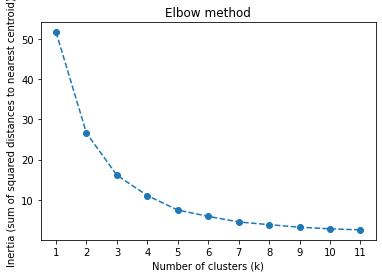

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scale the elec prices to be between 0 and 1
min_elec = df_daily['cost_elec'].min()
max_elec = df_daily['cost_elec'].max()
df_daily['cost_elec'] = (df_daily['cost_elec'] - min_elec) / (max_elec - min_elec)

# Scale the loads to be between 0 and 1
min_load = df_daily['m_load'].min()
max_load = df_daily['m_load'].max()
df_daily['m_load'] = (df_daily['m_load'] - min_load) / (max_load - min_load)

# Scale the temperatures between 0 and 1
min_temp = df_daily['T_OA'].min()
max_temp = df_daily['T_OA'].max()
df_daily['T_OA'] = (df_daily['T_OA'] - min_temp) / (max_temp - min_temp)

# Finding the best k for k-means clustering
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_daily)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 12), inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (sum of squared distances to nearest centroid)')
plt.title('Elbow method')
plt.xticks(range(1, 12))
plt.show()

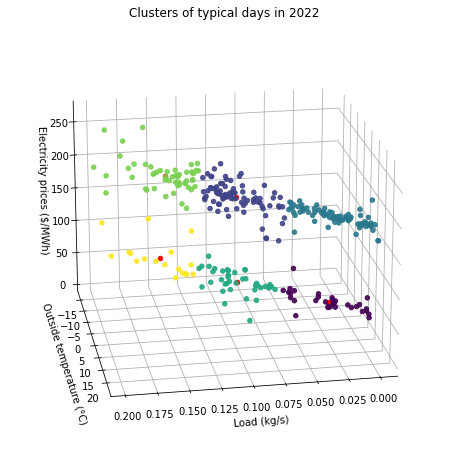

In [7]:
# Get the clusters
kmeans = KMeans(n_clusters=6, random_state=42).fit(df_daily)

# Undo the scaling
df_daily['cost_elec'] = df_daily['cost_elec'] * (max_elec - min_elec) + min_elec
df_daily['m_load'] = df_daily['m_load'] * (max_load - min_load) + min_load
df_daily['T_OA'] = df_daily['T_OA'] * (max_temp - min_temp) + min_temp

# Plot the clusters and their centroids
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_daily.m_load, df_daily.T_OA, df_daily.cost_elec, c=kmeans.labels_, alpha=0.9)

for c in kmeans.cluster_centers_:
    c[0] = c[0] * (max_elec - min_elec) + min_elec
    c[1] = c[1] * (max_load - min_load) + min_load
    c[2] = c[2] * (max_temp - min_temp) + min_temp
    ax.scatter(c[1], c[2], c[0], marker="o", color="red")
    ax.set_xlabel("Load (kg/s)")
    ax.set_ylabel("Outside temperature (°C)")
    ax.set_zlabel("Electricity prices ($/MWh)")
    ax.set_title("Clusters of typical days in 2022")
    
# Get rid of the panes
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.view_init(20, 80)
plt.savefig("clusters_3D.png")
plt.show()

In [8]:
# Get cluster labels for each row in df_daily
cluster_labels = kmeans.labels_

# Add cluster labels to df_daily as a new column
df_daily['cluster'] = cluster_labels
df_daily_cluster = df_daily

# Add date again
df_daily_cluster = df_daily_cluster.merge(df_daily_with_date, left_index=True, right_index=True, suffixes=('', '_df2'))
df_daily_cluster = df_daily_cluster.drop(df_daily_cluster.columns[[5,6,7]], axis=1)
df_daily_cluster = df_daily_cluster[['date', 'cost_elec', 'm_load', 'T_OA', 'cluster']]
df_daily_cluster.head()

,date,cost_elec,m_load,T_OA,cluster
0,2022-01-01,176.581667,0.115542,-1.759583,1
1,2022-01-02,172.049583,0.105833,0.022500,1
2,2022-01-03,188.702083,0.097917,1.410833,1
3,2022-01-04,56.554167,0.099833,1.041250,3
4,2022-01-05,58.674167,0.124250,-3.334167,5


In [9]:
for i in range(6):
    c = kmeans.cluster_centers_[i]
    print(f"Cluster {i}:")
    print(f"- Centroid: ({round(c[0],2)}, {round(c[1],2)}, {round(c[2],2)})")
    print(f"- Count: {len(df_daily_cluster[df_daily_cluster['cluster']==i])}\n")

Cluster 0:
- Centroid: (64.68, 0.03, 13.91)
- Count: 32

Cluster 1:
- Centroid: (187.67, 0.09, 2.21)
- Count: 88

Cluster 2:
- Centroid: (189.24, 0.03, 14.71)
- Count: 78

Cluster 3:
- Centroid: (62.51, 0.09, 2.34)
- Count: 40

Cluster 4:
- Centroid: (197.47, 0.14, -6.91)
- Count: 52

Cluster 5:
- Centroid: (72.15, 0.15, -7.73)
- Count: 18



In [10]:
number = 2
#data_column = 'm_load'
data_column = 'cost_elec'

In [11]:
df_cluster1 = df_daily_cluster[df_daily_cluster['cluster']==number].reset_index().drop('index',axis=1)

dict_hourly = {}
for i in range(24):
    key = f'hour{i}'
    dict_hourly[key] = []

# For each row (date), get corresponding cost_elec, m_load, T_OA in df at hour 0
for i in range(len(df_cluster1)):
    current_date = df_cluster1.date[i]
    current_date_hours = df[df['date']== current_date].reset_index()
    #print(current_date_hours)
    
    # Filter out the part of the df that is at time j
    current_data_hours_hour0 = current_date_hours[current_date_hours['hour']=='00:00'].reset_index()
    current_data_hours_hour1 = current_date_hours[current_date_hours['hour']=='01:00'].reset_index()
    current_data_hours_hour2 = current_date_hours[current_date_hours['hour']=='02:00'].reset_index()
    current_data_hours_hour3 = current_date_hours[current_date_hours['hour']=='03:00'].reset_index()
    current_data_hours_hour4 = current_date_hours[current_date_hours['hour']=='04:00'].reset_index()
    current_data_hours_hour5 = current_date_hours[current_date_hours['hour']=='05:00'].reset_index()
    current_data_hours_hour6 = current_date_hours[current_date_hours['hour']=='06:00'].reset_index()
    current_data_hours_hour7 = current_date_hours[current_date_hours['hour']=='07:00'].reset_index()
    current_data_hours_hour8 = current_date_hours[current_date_hours['hour']=='08:00'].reset_index()
    current_data_hours_hour9 = current_date_hours[current_date_hours['hour']=='09:00'].reset_index()
    current_data_hours_hour10 = current_date_hours[current_date_hours['hour']=='10:00'].reset_index()
    current_data_hours_hour11 = current_date_hours[current_date_hours['hour']=='11:00'].reset_index()
    current_data_hours_hour12 = current_date_hours[current_date_hours['hour']=='12:00'].reset_index()
    current_data_hours_hour13 = current_date_hours[current_date_hours['hour']=='13:00'].reset_index()
    current_data_hours_hour14 = current_date_hours[current_date_hours['hour']=='14:00'].reset_index()
    current_data_hours_hour15 = current_date_hours[current_date_hours['hour']=='15:00'].reset_index()
    current_data_hours_hour16 = current_date_hours[current_date_hours['hour']=='16:00'].reset_index()
    current_data_hours_hour17 = current_date_hours[current_date_hours['hour']=='17:00'].reset_index()
    current_data_hours_hour18 = current_date_hours[current_date_hours['hour']=='18:00'].reset_index()
    current_data_hours_hour19 = current_date_hours[current_date_hours['hour']=='19:00'].reset_index()
    current_data_hours_hour20 = current_date_hours[current_date_hours['hour']=='20:00'].reset_index()
    current_data_hours_hour21 = current_date_hours[current_date_hours['hour']=='21:00'].reset_index()
    current_data_hours_hour22 = current_date_hours[current_date_hours['hour']=='22:00'].reset_index()
    current_data_hours_hour23 = current_date_hours[current_date_hours['hour']=='23:00'].reset_index()
    #print(current_data_hours_hour7)

    if (len(current_data_hours_hour0) != 0) & (len(current_data_hours_hour2) != 0): 

        if current_data_hours_hour0.level_0[0] == 0: 
            dict_hourly['hour0'].append(round(current_data_hours_hour0[data_column][0],3))
            dict_hourly['hour1'].append(round(current_data_hours_hour1[data_column][0],3))
            dict_hourly['hour2'].append(round(current_data_hours_hour2[data_column][0],3))
            dict_hourly['hour3'].append(round(current_data_hours_hour3[data_column][0],3))
            dict_hourly['hour4'].append(round(current_data_hours_hour4[data_column][0],3))
            dict_hourly['hour5'].append(round(current_data_hours_hour5[data_column][0],3))
            dict_hourly['hour6'].append(round(current_data_hours_hour6[data_column][0],3))
            dict_hourly['hour7'].append(round(current_data_hours_hour7[data_column][0],3))
            dict_hourly['hour8'].append(round(current_data_hours_hour8[data_column][0],3))
            dict_hourly['hour9'].append(round(current_data_hours_hour9[data_column][0],3))
            dict_hourly['hour10'].append(round(current_data_hours_hour10[data_column][0],3))
            dict_hourly['hour11'].append(round(current_data_hours_hour11[data_column][0],3))
            dict_hourly['hour12'].append(round(current_data_hours_hour12[data_column][0],3))
            dict_hourly['hour13'].append(round(current_data_hours_hour13[data_column][0],3))
            dict_hourly['hour14'].append(round(current_data_hours_hour14[data_column][0],3))
            dict_hourly['hour15'].append(round(current_data_hours_hour15[data_column][0],3))
            dict_hourly['hour16'].append(round(current_data_hours_hour16[data_column][0],3))
            dict_hourly['hour17'].append(round(current_data_hours_hour17[data_column][0],3))
            dict_hourly['hour18'].append(round(current_data_hours_hour18[data_column][0],3))
            dict_hourly['hour19'].append(round(current_data_hours_hour19[data_column][0],3))
            dict_hourly['hour20'].append(round(current_data_hours_hour20[data_column][0],3))
            dict_hourly['hour21'].append(round(current_data_hours_hour21[data_column][0],3))
            dict_hourly['hour22'].append(round(current_data_hours_hour22[data_column][0],3))
            dict_hourly['hour23'].append(round(current_data_hours_hour23[data_column][0],3))
        
        elif current_data_hours_hour0.level_0[0] == 22: 
            dict_hourly['hour0'].append(round(current_data_hours_hour1[data_column][0],3))
            dict_hourly['hour1'].append(round(current_data_hours_hour2[data_column][0],3))
            dict_hourly['hour2'].append(round(current_data_hours_hour3[data_column][0],3))
            dict_hourly['hour3'].append(round(current_data_hours_hour4[data_column][0],3))
            dict_hourly['hour4'].append(round(current_data_hours_hour5[data_column][0],3))
            dict_hourly['hour5'].append(round(current_data_hours_hour6[data_column][0],3))
            dict_hourly['hour6'].append(round(current_data_hours_hour7[data_column][0],3))
            dict_hourly['hour7'].append(round(current_data_hours_hour8[data_column][0],3))
            dict_hourly['hour8'].append(round(current_data_hours_hour9[data_column][0],3))
            dict_hourly['hour9'].append(round(current_data_hours_hour10[data_column][0],3))
            dict_hourly['hour10'].append(round(current_data_hours_hour11[data_column][0],3))
            dict_hourly['hour11'].append(round(current_data_hours_hour12[data_column][0],3))
            dict_hourly['hour12'].append(round(current_data_hours_hour13[data_column][0],3))
            dict_hourly['hour13'].append(round(current_data_hours_hour14[data_column][0],3))
            dict_hourly['hour14'].append(round(current_data_hours_hour15[data_column][0],3))
            dict_hourly['hour15'].append(round(current_data_hours_hour16[data_column][0],3))
            dict_hourly['hour16'].append(round(current_data_hours_hour17[data_column][0],3))
            dict_hourly['hour17'].append(round(current_data_hours_hour18[data_column][0],3))
            dict_hourly['hour18'].append(round(current_data_hours_hour19[data_column][0],3))
            dict_hourly['hour19'].append(round(current_data_hours_hour20[data_column][0],3))
            dict_hourly['hour20'].append(round(current_data_hours_hour21[data_column][0],3))
            dict_hourly['hour21'].append(round(current_data_hours_hour22[data_column][0],3))
            dict_hourly['hour22'].append(round(current_data_hours_hour23[data_column][0],3))
            dict_hourly['hour23'].append(round(current_data_hours_hour0[data_column][0],3))

    else: print("Discarded a data point")
        
#print(dict_hourly)

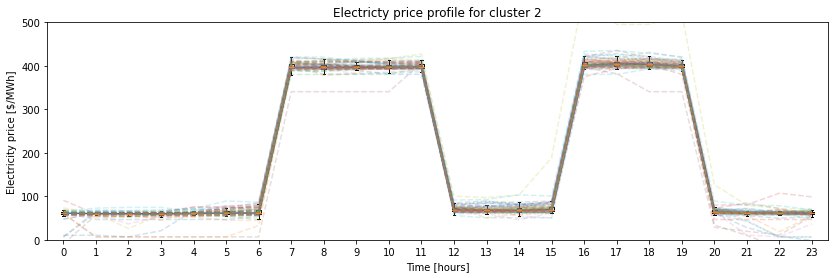

In [12]:
# Find the average price and load forecast for the elements in each cluster. Remove outliers?
plt.figure(figsize=(14,4), facecolor='white')
for j in range(24):
    plt.boxplot(dict_hourly[f"hour{j}"], positions=[j], showfliers=False)
    plt.xlabel("Time [hours]")
    if data_column == 'cost_elec':
        plt.ylabel("Electricity price [$/MWh]")
        plt.title(f"Electricty price profile for cluster {number}")
        plt.ylim([0,500])
    else:
        plt.ylabel("Load mass flow rate (kg/s)")
        plt.title(f"Load profile for cluster {number}")
        plt.ylim([0,0.3])

# Plot the prices by median
medians = [round(np.median(dict_hourly[f"hour{j}"]),2) for j in range(24)]
plt.plot(medians)

for j in range(len(dict_hourly['hour0'])):
    plt.plot([value[j] for value in dict_hourly.values()], alpha = 0.2, linestyle='dashed', label=f"{j}")

if data_column=='cost_elec': plt.savefig(f"elec_cluster{number}.png")
else: plt.savefig(f"load_cluster{number}.png") 
plt.show()

In [13]:
if data_column == 'cost_elec':
    # Convert to cts/kWh
    medians = [round(x/1000*100,2) for x in medians]
    print(medians)

else: 
    print(medians)

[6.12, 6.03, 6.01, 6.0, 6.09, 6.14, 6.18, 39.63, 39.7, 39.65, 39.71, 39.8, 6.86, 6.77, 6.77, 6.95, 40.1, 40.47, 40.34, 39.92, 6.39, 6.19, 6.09, 6.1]
